In [1]:
import sys
import os
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(script_dir)
sys.path.insert(0, parent_dir)

import functions
import models
import gradcam
import pickle
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

In [2]:
# Use the GPU instead of the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the label maps
binary_labels_map = {
    0: "REAL",
    1: "FAKE"
}
with open(os.path.join(script_dir, '../../dataset/imagenet_classes.txt'), 'r') as file:
    labels = [line.strip() for line in file.readlines()]
multiclass_labels_map = {index: label for index, label in enumerate(labels)}

# Compose the transform that will be applied to the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 324k samples for training
train_ds = functions.MulticlassGenImage(img_dir=os.path.join(script_dir, '../../dataset/stable_diffusion_1_4/train'), transform=transform)

# 6k samples for validation and 6k samples for testing
val_test_ds= functions.MulticlassGenImage(img_dir=os.path.join(script_dir, '../../dataset/stable_diffusion_1_4/val'), transform=transform)
# Perform a stratified split
stratify_labels = [f"{label['binary']}{label['multiclass']}" for label in val_test_ds.img_labels]
idx_val, idx_test = train_test_split(
    range(len(val_test_ds)),
    test_size=0.5,  # 50-50 split
    stratify=stratify_labels, # Uniform class distribution
    random_state=0
)
validation_ds = Subset(val_test_ds, idx_val)
test_ds = Subset(val_test_ds, idx_test)

cuda


# Untrained model



 - multiclass_untrained_batch64
Epoch 1: current lr = 1e-02
Train error: Combined=90.86%; Binary=9.49%; multiclass=89.90%; 
Validation error: Combined=91.25%; Binary=10.12%; multiclass=90.30%; 
Loss: 2.653e+00
Epoch 2: current lr = 1e-02
Train error: Combined=90.75%; Binary=8.35%; multiclass=89.88%; 
Validation error: Combined=90.33%; Binary=9.07%; multiclass=89.38%; 
Loss: 2.537e+00
Epoch 3: current lr = 1e-02
Train error: Combined=91.47%; Binary=15.77%; multiclass=89.82%; 
Validation error: Combined=91.60%; Binary=16.60%; multiclass=89.85%; 
Loss: 2.486e+00
Epoch 4: current lr = 1e-02
Train error: Combined=90.55%; Binary=8.01%; multiclass=89.71%; 
Validation error: Combined=90.83%; Binary=9.45%; multiclass=89.65%; 
Loss: 2.446e+00
Epoch 5: current lr = 1e-03
Train error: Combined=89.41%; Binary=1.85%; multiclass=89.21%; 
Validation error: Combined=90.12%; Binary=2.67%; multiclass=89.85%; 
Loss: 2.367e+00
Epoch 10: current lr = 1e-05
Train error: Combined=88.15%; Binary=0.98%; multi

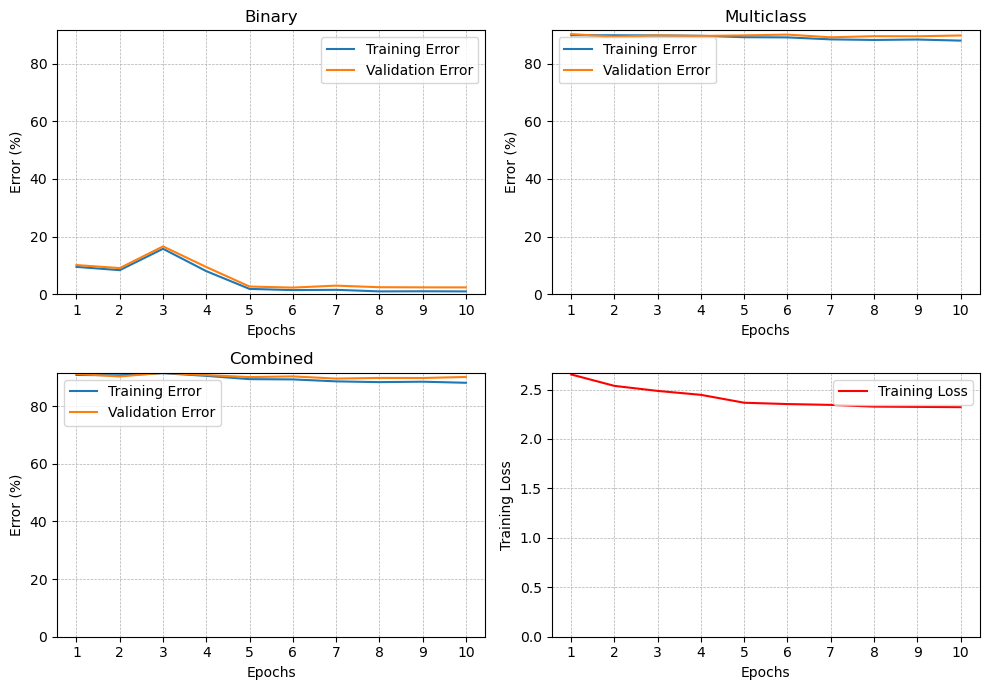

KeyError: 0

In [3]:
model_init_function = models.multiclass_untrained
epochs = 15
batch_size = 64
lr = 0.01
val_batch_size = 64

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=4)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['binary'])}"

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

# Finetuning of the pretrained model



 - multiclass_finetuning_batch64
Epoch 1: current lr = 1e-03
Train error: Combined=89.70%; Binary=0.88%; multiclass=89.61%; 
Validation error: Combined=89.83%; Binary=1.20%; multiclass=89.68%; 
Loss: 2.453e+00
Epoch 2: current lr = 1e-03
Train error: Combined=88.67%; Binary=0.44%; multiclass=88.62%; 
Validation error: Combined=90.10%; Binary=1.15%; multiclass=89.97%; 
Loss: 2.349e+00
Epoch 3: current lr = 1e-03
Train error: Combined=87.40%; Binary=0.17%; multiclass=87.38%; 
Validation error: Combined=90.13%; Binary=0.97%; multiclass=90.07%; 
Loss: 2.325e+00
Epoch 4: current lr = 1e-03
Train error: Combined=84.56%; Binary=0.22%; multiclass=84.53%; 
Validation error: Combined=89.87%; Binary=1.27%; multiclass=89.80%; 
Loss: 2.308e+00
Epoch 5: current lr = 1e-04
Train error: Combined=81.30%; Binary=0.01%; multiclass=81.30%; 
Validation error: Combined=89.77%; Binary=0.75%; multiclass=89.75%; 
Loss: 2.253e+00
Stopping training...


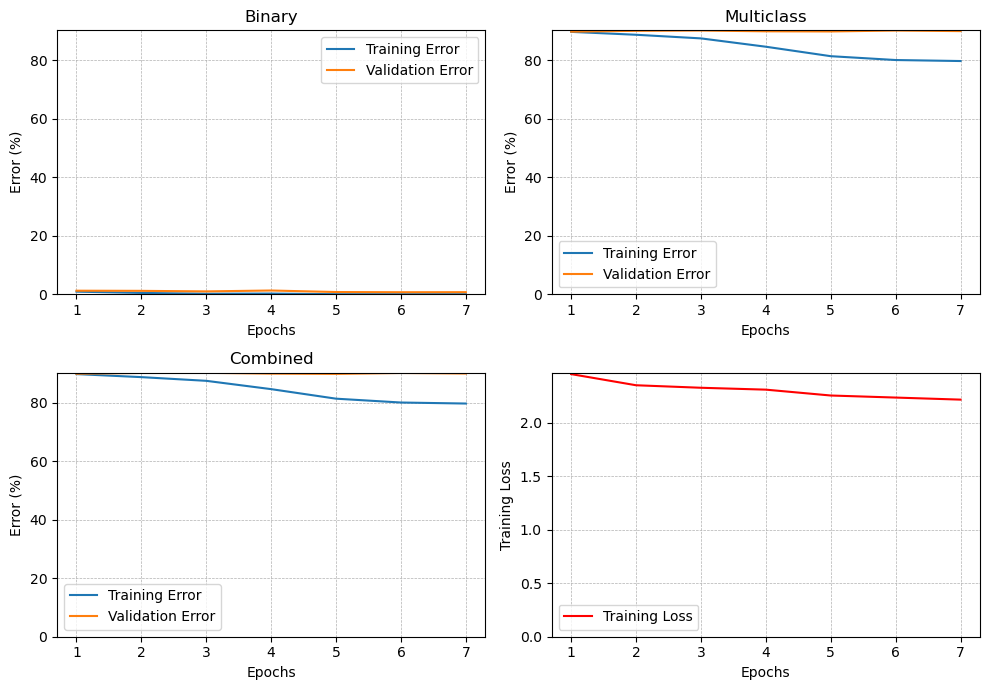

In [3]:
model_init_function = models.multiclass_finetuning
epochs = 15
batch_size = 64
lr = 0.001
val_batch_size = 64

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=4)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['binary'])}"

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

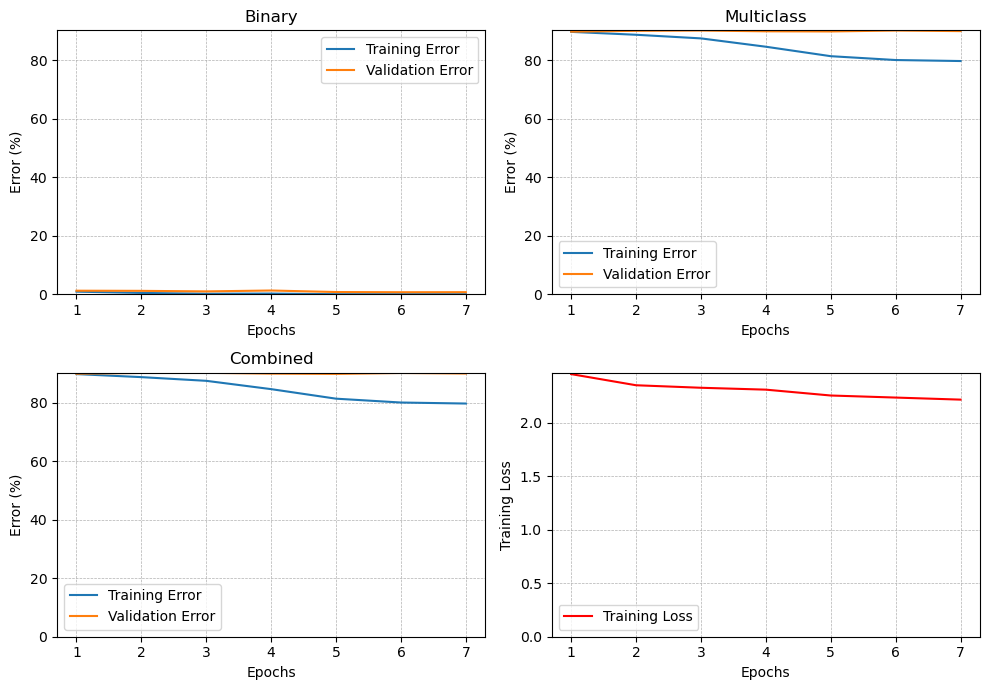

In [7]:
model_name = 'multiclass_finetuning_batch64_epochs7'
with open('./stats/' + model_name + '.pkl', 'rb') as f:
    stats = pickle.load(f)

functions.plot_training_stats_multioutput(stats['train_errors'], stats['val_errors'], stats['train_loss'])

In [3]:
model = models.multiclass_finetuning()
model.load_state_dict(torch.load('./weights/multiclass_finetuning_batch64_epochs7.pth'))
sample_idx = torch.randint(len(train_ds), size=(1,)).item()

gradcam.plot_gradcam_multioutput(model, model.features[4][0], train_ds, binary_labels_map, 'binary', sample_idx)

TypeError: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.